In [59]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mutual_info_score

import joblib
import os
import yaml
from IPython.display import display

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


# folder to load config file
CONFIG_PATH = "./config/"

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config


config = load_config("my_config.yaml")


# load data
data = pd.read_csv(os.path.join(config["data_directory"], config["data_name"]))
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


<Axes: title={'center': 'Decile Score Histogram by Race'}, xlabel='race', ylabel='% with Decile Score'>

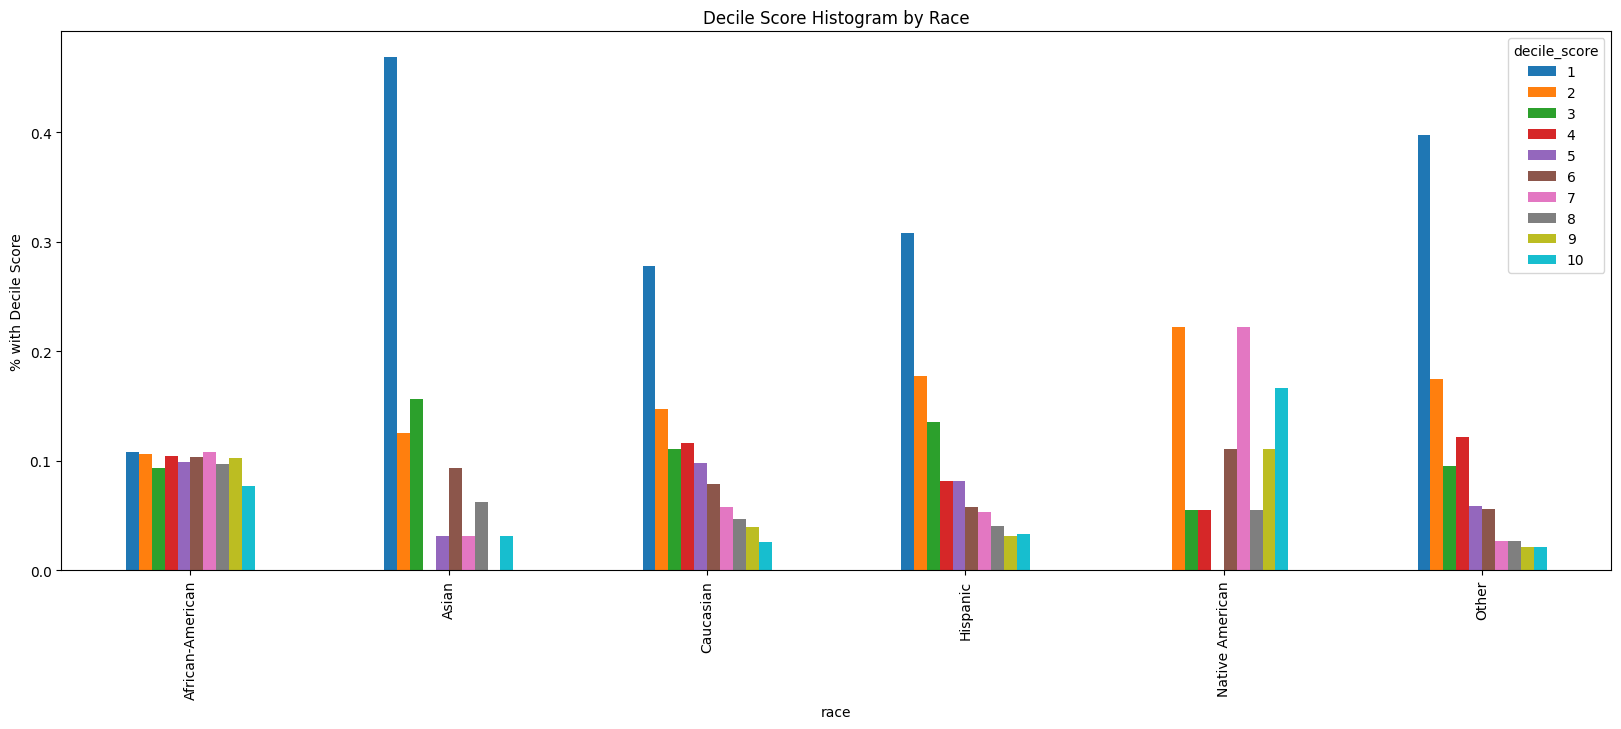

In [60]:
data.groupby('race')['decile_score'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar', figsize=(20, 7),
    title='Decile Score Histogram by Race', ylabel='% with Decile Score'
)

In [61]:
data.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Asian,32.0,0.281250,0.456803,0.0,0.0,0.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Native American,18.0,0.555556,0.511310,0.0,0.0,1.0,1.0,1.0
Other,377.0,0.352785,0.478472,0.0,0.0,0.0,1.0,1.0


In [62]:
# Courts generally use  a decile score of 5 to label someone as being medium risk.
data['is_med_or_high_risk'] = (data['decile_score']>=5).astype(bool)

In [63]:
# Hmm, not great if the court's system of 5 or higher on the decile score is only accurate 65% of the time
(data['is_med_or_high_risk']==data['two_year_recid']).mean()

0.6537288605489326

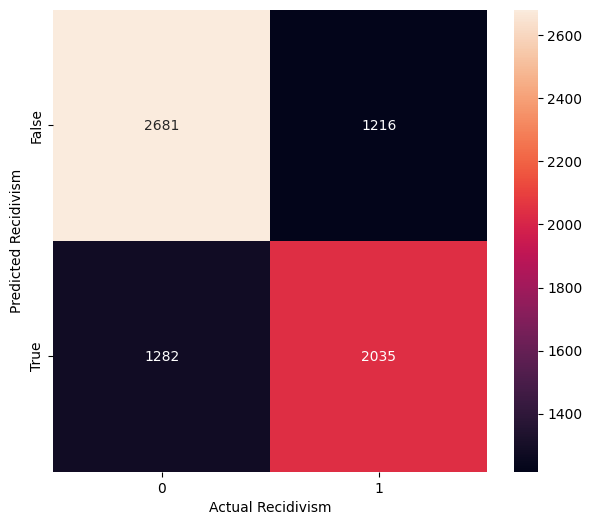

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# heatmap of recidivism
cm = pd.crosstab(
    data['is_med_or_high_risk'], data['two_year_recid'], 
    rownames=['Predicted Recidivism'], colnames=['Actual Recidivism']
)
p = plt.figure(figsize=(7,6))
p = sns.heatmap(cm, annot=True, fmt='d')

<Axes: title={'center': 'Recidivism vs Decile Score by Race'}, xlabel='Decile Score', ylabel='Recidivism Rate'>

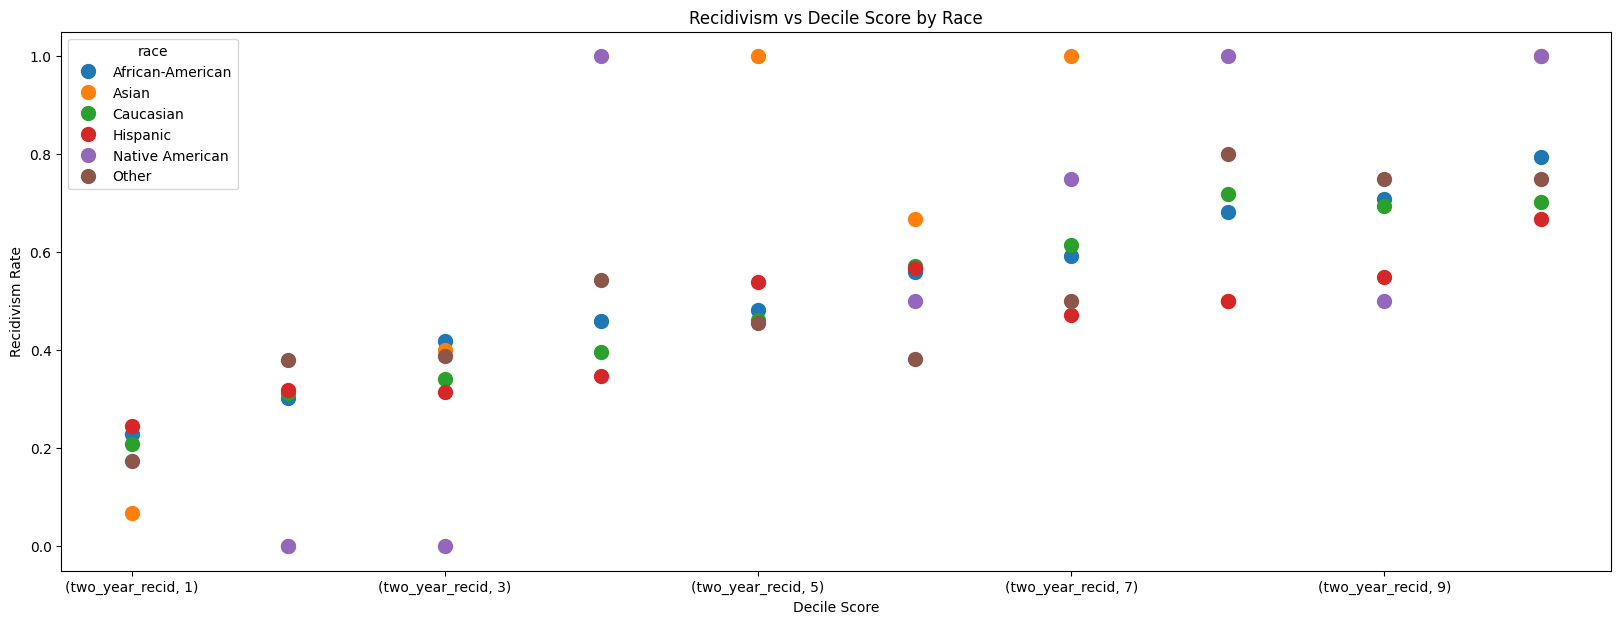

In [65]:
# scatter plot 
data.groupby(
    ['race', 'decile_score']
)[['two_year_recid']].mean().unstack().T.plot(
    xlabel='Decile Score', ylabel='Recidivism Rate', title='Recidivism vs Decile Score by Race',
    style='.', figsize=(20, 7),
    ms=20
)

In [66]:
data['race'].value_counts(normalize=True)

African-American    0.512337
Caucasian           0.340172
Hispanic            0.088301
Other               0.052259
Asian               0.004436
Native American     0.002495
Name: race, dtype: float64

In [67]:
# re-label two races as Other. 
# This is done purely for educational reasons and to avoid addressing issues with a skewed sample in our data
data.loc[data['race'].isin(['Native American', 'Asian']), 'race'] = 'Other'

In [68]:
data.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Other,427.0,0.355972,0.479368,0.0,0.0,0.0,1.0,1.0


<Axes: title={'center': 'Actual Recidivism Rates by Race'}, xlabel='race'>

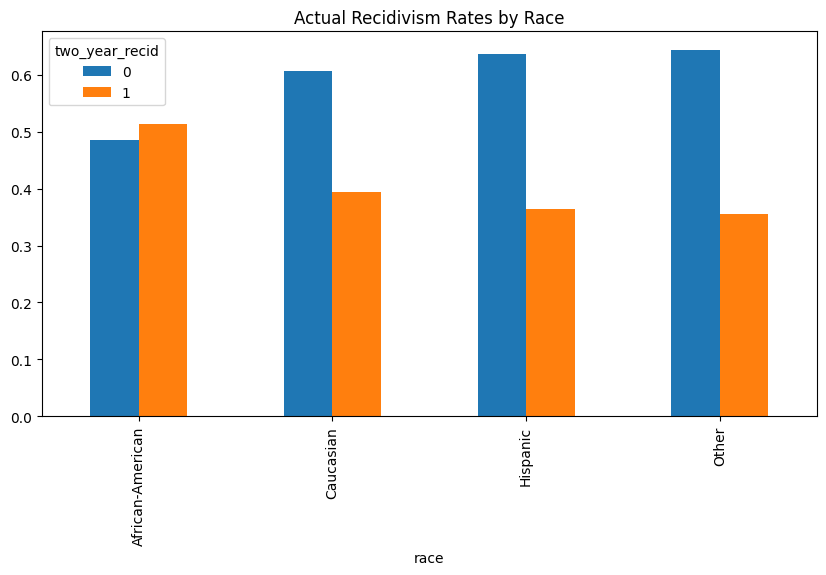

In [69]:
data.groupby('race')['two_year_recid'].value_counts(
    normalize=True
).unstack().plot(
    kind='bar', figsize=(10, 5), title='Actual Recidivism Rates by Race'
)

<Axes: title={'center': '% of Charge Degree'}, xlabel='Charge Degree', ylabel='%'>

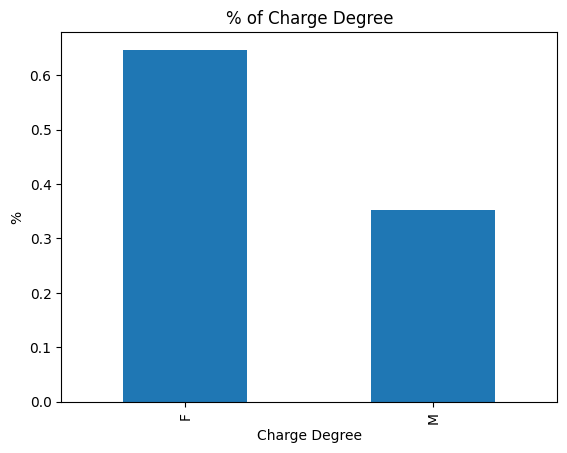

In [70]:
data['c_charge_degree'].value_counts(normalize=True).plot(
    kind='bar', title='% of Charge Degree', ylabel='%', xlabel='Charge Degree'
)

<Axes: title={'center': 'Histogram of Age'}, ylabel='Frequency'>

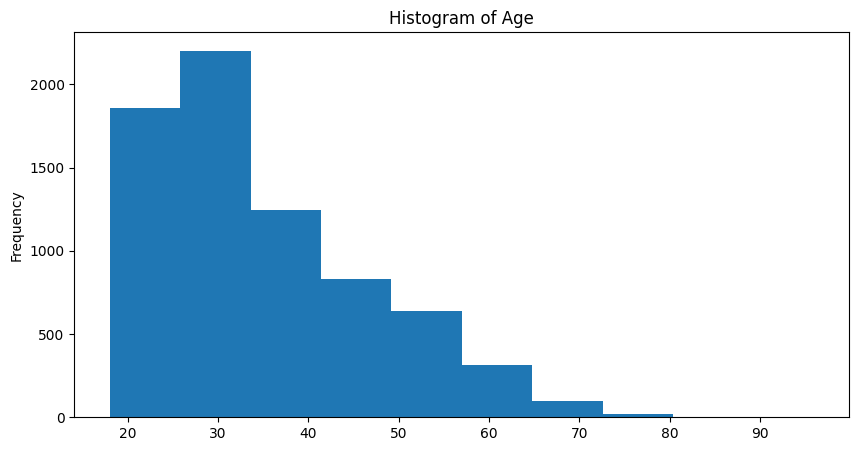

In [71]:
# Right skew on Age
data['age'].plot(
    title='Histogram of Age', kind='hist', xlabel='Age', figsize=(10, 5)
)

<Axes: title={'center': 'Histogram of Priors Count'}, ylabel='Frequency'>

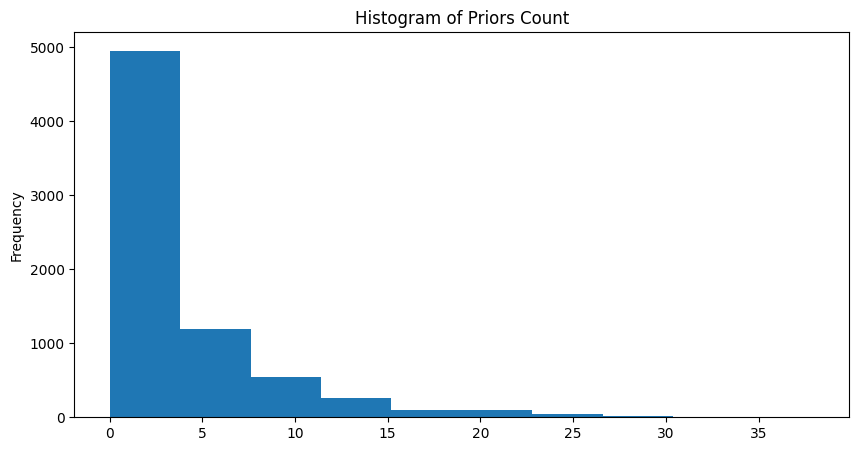

In [72]:
data['priors_count'].plot(
    title='Histogram of Priors Count', kind='hist', xlabel='Priors', figsize=(10, 5)
)

# Measuring bias and fairness

In [73]:
data.select_dtypes(include=np.number).columns

Index(['id', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_days_from_compas', 'is_recid', 'r_days_from_arrest', 'violent_recid',
       'is_violent_recid', 'decile_score.1', 'v_decile_score',
       'priors_count.1', 'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [74]:
data.select_dtypes(include='object').columns

Index(['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age_cat', 'race', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_charge_degree', 'c_charge_desc',
       'r_case_number', 'r_charge_degree', 'r_offense_date', 'r_charge_desc',
       'r_jail_in', 'r_jail_out', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'score_text',
       'screening_date', 'v_type_of_assessment', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody'],
      dtype='object')

# Feature construction

In [75]:
data[["juv_fel_count", "juv_misd_count", "juv_other_count"]].describe()

,juv_fel_count,juv_misd_count,juv_other_count
count,7214.000000,7214.000000,7214.000000
mean,0.067230,0.090934,0.109371
std,0.473972,0.485239,0.501586
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,20.000000,13.000000,17.000000


In [76]:
# feature construction, add up our three juv columns and remove the original features
data['juv_count'] = data[["juv_fel_count", "juv_misd_count", "juv_other_count"]].sum(axis=1)

data[['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'juv_count']].describe()

,juv_fel_count,juv_misd_count,juv_other_count,juv_count
count,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.067230,0.090934,0.109371,0.267535
std,0.473972,0.485239,0.501586,0.952763
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,20.000000,13.000000,17.000000,21.000000


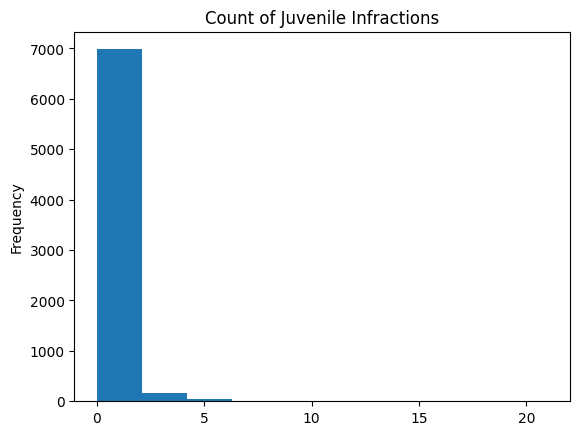

In [77]:
data['juv_count'].plot(
    title='Count of Juvenile Infractions', kind='hist', xlabel='Count'
)

name = 'juv_count'
plt.savefig(f'{name}.svg', dpi=500)
plt.savefig(f'{name}.png', dpi=500)

In [78]:
data['juv_count'].mean(), data['juv_count'].std()

(0.2675353479345717, 0.952763227517296)

In [79]:
data = data.drop(["juv_fel_count", "juv_misd_count", "juv_other_count"], axis=1)

# Building our baseline pipeline

In [80]:
X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(
    data.drop('two_year_recid', axis=1), 
    data['two_year_recid'],
    data['race'],
    stratify=data['two_year_recid'],
    test_size=0.3,
    random_state=0
)

# our static classifier
classifier = RandomForestClassifier(max_depth=10, n_estimators=20, random_state=0)

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler


categorical_features = ['race', 'sex', 'c_charge_degree']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary'))
])

numerical_features = ["age", "priors_count"]
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
])

clf_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


clf_tree.fit(X_train, y_train)

unaware_y_preds = clf_tree.predict(X_test)

In [82]:
preprocessor.fit_transform(X_train).shape

(5049, 8)

# Measuring bias in our baseline model


In [83]:
!pip install dalex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
import dalex as dx

exp_tree = dx.Explainer(clf_tree, X_test, y_test, label='Random Forest Bias Unaware', verbose=True)

Preparation of a new explainer is initiated

  -> data              : 2165 rows 51 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2165 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest Bias Unaware
  -> predict function  : <function yhat_proba_default at 0x7f87c49b6b90> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.444, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.986, mean = 0.00662, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


In [85]:
exp_tree.model_performance()

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.69393


In [86]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=unaware_y_preds))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1189
           1       0.63      0.56      0.59       976

    accuracy                           0.65      2165
   macro avg       0.65      0.64      0.65      2165
weighted avg       0.65      0.65      0.65      2165



In [87]:
exp_tree.model_parts().plot()

Dalex is reporting importance in terms of drop-out loss, or how much the overall fit of our model would decrease if the feature in question were entirely removed. According to this chart, our model would lose a lot of information if we lost priors_count, but in theory, it would have been better if we dropped race. It would seem that our model isn’t even learning from the race at all! This speaks to the model’s unawareness of sensitive features.

In [88]:
y_test.groupby(race_test).mean()                         
 
pd.Series(unaware_y_preds, index=y_test.index).groupby(
    race_test).mean()      

race
African-American    0.508242
Caucasian           0.285146
Hispanic            0.255556
Other               0.381295
dtype: float64

In [89]:
mf_tree = exp_tree.model_fairness(protected=race_test, privileged='Caucasian')
mf_tree.fairness_check()

Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.633907  1.035994  1.160069  1.701493  1.782456
Hispanic          0.874693  1.007825  0.769363  1.069652  0.915789
Other             1.380835  1.035994  0.876076  1.422886  1.336842


In [90]:
# mf_tree = exp_tree.model_fairness(
#     protected=race_test, privileged = "Caucasian")
mf_tree.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
African-American,0.665,0.658,0.674,0.650,0.335,0.342,0.326,0.350,0.662,0.508
Caucasian,0.407,0.799,0.581,0.662,0.593,0.201,0.419,0.338,0.639,0.285
Hispanic,0.356,0.785,0.447,0.714,0.644,0.215,0.553,0.286,0.644,0.261
Other,0.562,0.714,0.509,0.756,0.438,0.286,0.491,0.244,0.662,0.381


In [91]:
mf_tree.plot()

In [92]:
mf_tree.plot(type = 'stacked')

In [93]:
def show_proportions(sensitive_features, y_pred, y=None, description=None):
    print(f'\n{description}\n')
    indices = {}
    positive_indices = {}
    negative_indices = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    max_group_length = max([len(group) for group in groups])
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        group_recidivism_pct = round(sum(y_pred[indices[group]]) / len(indices[group]), 5)
        buffer = " " * (max_group_length - len(group))
        print(f'P(recidivism | {group})                {buffer}= {group_recidivism_pct}')

        if y is not None:
            positive_indices[group] = sensitive_features.index[
                (sensitive_features == group) & (y == True)
            ]
            negative_indices[group] = sensitive_features.index[
                (sensitive_features == group) & (y == False)
            ]
            prob_1 = round(sum(y_pred[positive_indices[group]]) / len(positive_indices[group]), 5)
            prob_0 = round(sum(y_pred[negative_indices[group]]) / len(negative_indices[group]), 5)
            
            print(f'P(recidivism | {group}, recidivism)    {buffer}= {prob_1}')
            print(f'P(recidivism | {group}, no recidivism) {buffer}= {prob_0}')

In [94]:
show_proportions(
    race_test,
    y_test,
    description="original test data:"
)
show_proportions(
    race_test,
    pd.Series(unaware_y_preds, index=y_test.index),
    y=y_test,
    description="fairness-unaware prediction on test data:"
)
plt.show()


original test data:

P(recidivism | African-American)                = 0.51465
P(recidivism | Caucasian)                       = 0.40716
P(recidivism | Hispanic)                        = 0.32778
P(recidivism | Other)                           = 0.34532

fairness-unaware prediction on test data:

P(recidivism | African-American)                = 0.50824
P(recidivism | African-American, recidivism)    = 0.66548
P(recidivism | African-American, no recidivism) = 0.34151
P(recidivism | Caucasian)                       = 0.28515
P(recidivism | Caucasian, recidivism)           = 0.40717
P(recidivism | Caucasian, no recidivism)        = 0.20134
P(recidivism | Hispanic)                        = 0.25556
P(recidivism | Hispanic, recidivism)            = 0.35593
P(recidivism | Hispanic, no recidivism)         = 0.20661
P(recidivism | Other)                           = 0.38129
P(recidivism | Other, recidivism)               = 0.5625
P(recidivism | Other, no recidivism)            = 0.28571


# Mitigating bias


When it comes to mitigating bias and promoting fairness in our models, we have three main opportunities to do so:

Preprocessing—Bias mitigation, as applied to the training data (i.e., before the model has had a chance to train on the training data)

In-processing—Bias mitigation applied to a model during the training phase

Postprocessing—Bias mitigation applied to the predicted labels after the model has been fit to the training data

In [95]:
data.corrwith(data['race'] == 'African-American').sort_values()

<ipython-input-95-0b46f54afff5>:1: FutureWarning:

The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



age                       -0.179095
end                       -0.125003
r_days_from_arrest        -0.011710
id                         0.007618
days_b_screening_arrest    0.025486
c_days_from_compas         0.044657
start                      0.054466
is_violent_recid           0.065909
event                      0.110068
juv_count                  0.111835
two_year_recid             0.131200
is_recid                   0.143022
priors_count.1             0.202897
priors_count               0.202897
is_med_or_high_risk        0.264078
v_decile_score             0.285604
decile_score.1             0.308340
decile_score               0.308340
violent_recid                   NaN
dtype: float64

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,32.740801,10.858391,18.0,25.0,30.0,38.00,77.0
Caucasian,2454.0,37.726569,12.761373,18.0,27.0,35.0,47.75,83.0
Hispanic,637.0,35.455259,11.877783,19.0,26.0,33.0,43.00,96.0
Other,427.0,35.131148,11.634159,19.0,25.0,33.0,43.00,76.0


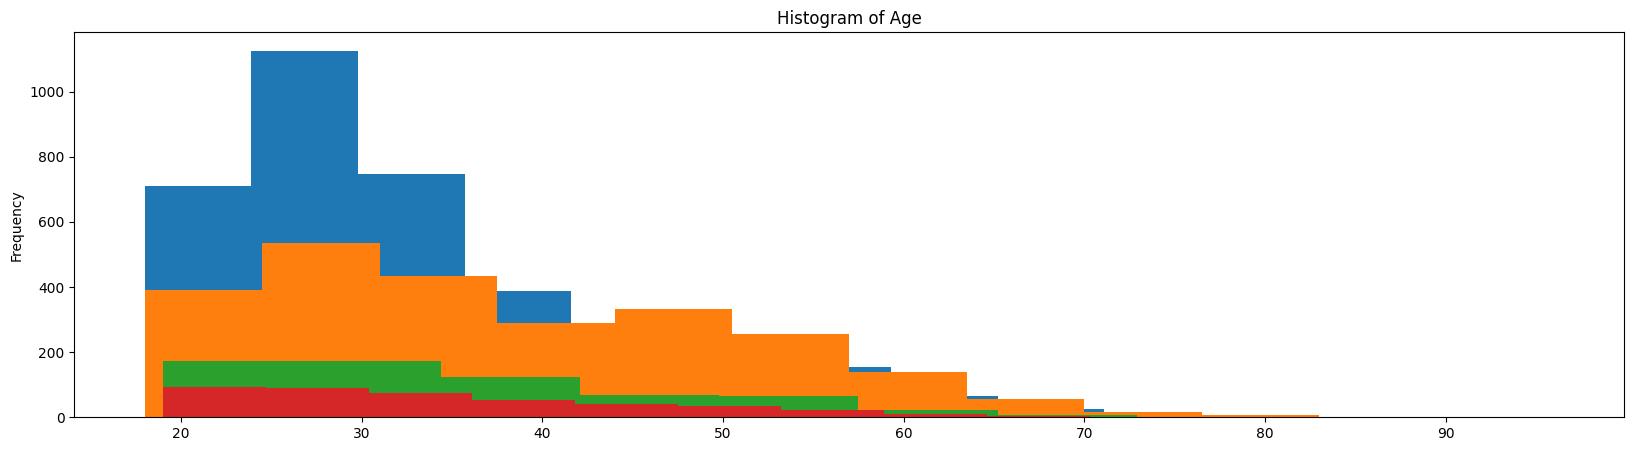

In [96]:
data.groupby('race')['age'].plot(
    figsize=(20,5), 
    kind='hist', xlabel='Age', title='Histogram of Age'    
)
data.groupby('race')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,4.438853,5.579835,0.0,1.0,2.0,6.0,38.0
Caucasian,2454.0,2.586797,3.798803,0.0,0.0,1.0,3.0,36.0
Hispanic,637.0,2.252747,3.647673,0.0,0.0,1.0,2.0,26.0
Other,427.0,2.016393,3.695856,0.0,0.0,1.0,2.5,31.0


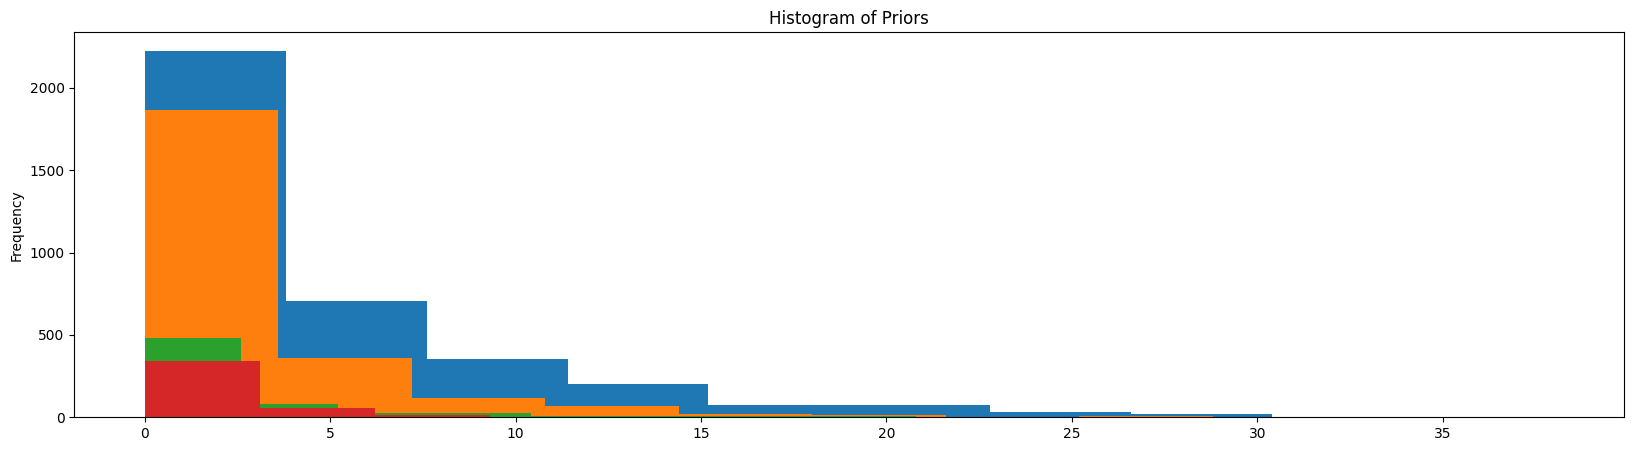

In [97]:
data.groupby('race')['priors_count'].plot(
    figsize=(20,5), 
    kind='hist', xlabel='Count of Priors', title='Histogram of Priors'
)
data.groupby('race')['priors_count'].describe()

here are two things to note:

African American priors are hugely right skewed, as evidenced by the mean being over twice the median.

African American priors are nearly twice as high as the other racial groups combined, due to a long history of systemic criminal justice issues.

The facts that priors_count is so correlated to race, and it is skewed differently for the different racial categories, are huge problems mainly because the ML model can likely pick up on these and bias itself against certain races, simply by looking at the priors_count column.

To remedy this, we will create a custom transformer that will modify a column in place by applying the Yeo-Johnson transformation—as discussed in our previous chapter—to each racial category’s subset of values. This will help to remove the disparate impact that this column would have on our group fairness.

By applying the transformation on each subset of values, rather than on the column as a whole, we are forcing each group’s set of values to be normal with a mean of 0 and a standard deviation of 1, making it harder for the model to reconstruct a particular group label from a given priors_count value. Let’s construct a custom scikit-learn transformer to perform this operation, as shown in the following listing.

In [98]:
from sklearn.preprocessing import PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class NormalizeColumnByLabel(BaseEstimator, TransformerMixin):
    def __init__(self, col, label):
        self.col = col
        self.label = label
        self.transformers = {}
        
    def fit(self, X, y=None):
        for group in X[self.label].unique():
            self.transformers[group] = PowerTransformer(
                method='yeo-johnson', standardize=True
            )
            self.transformers[group].fit(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return self
    
    def transform(self, X, y=None):
        C = X.copy()
        for group in X[self.label].unique():
            C.loc[X[self.label]==group, self.col] = self.transformers[group].transform(
                X.loc[X[self.label]==group][self.col].values.reshape(-1, 1)
            )
        return C

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,2604.0,-8.868141e-17,1.000192,-1.394037,-0.549932,-0.092417,0.784661,2.276224
Caucasian,1700.0,1.097162e-16,1.000294,-1.190914,-1.190914,-0.104396,0.733866,2.293665
Hispanic,457.0,-9.911838e-17,1.001096,-1.124116,-1.124116,0.098333,0.620238,2.060623
Other,288.0,1.572816e-16,1.001741,-0.921525,-0.921525,-0.921525,0.878567,1.871600


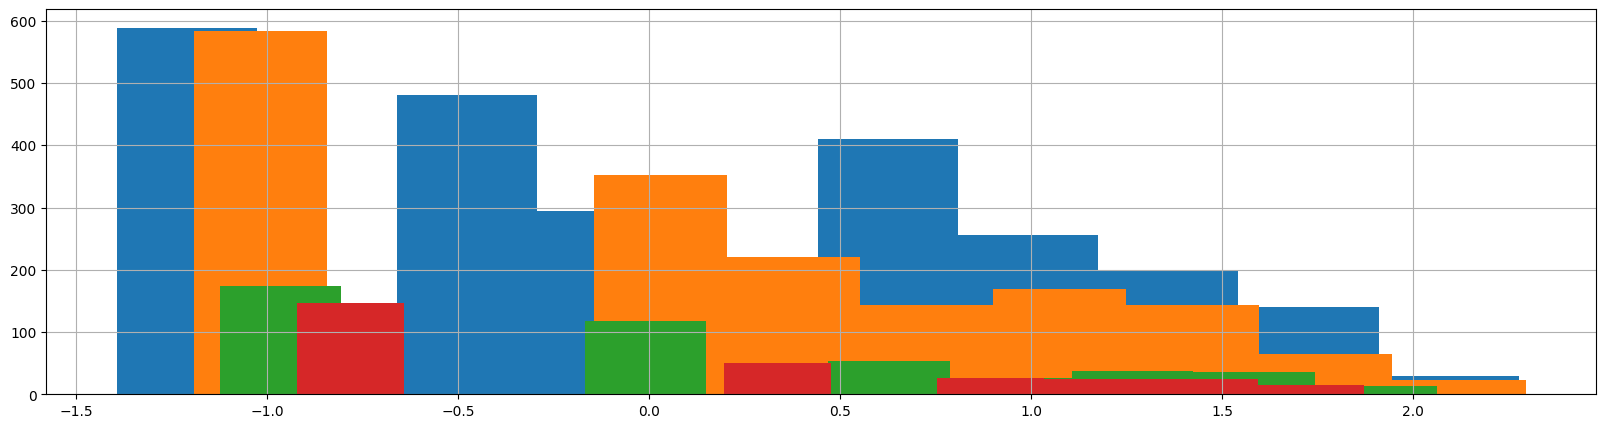

In [99]:
n = NormalizeColumnByLabel(col='priors_count', label='race')

X_train_normalized = n.fit_transform(X_train, y_train)

X_train_normalized.groupby('race')['priors_count'].hist(figsize=(20,5))
X_train_normalized.groupby('race')['priors_count'].describe()

In [100]:
clf_tree_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

clf_tree_aware.fit(X_train, y_train)

aware_y_preds = clf_tree_aware.predict(X_test)

In [101]:
print(classification_report(y_true=y_test, y_pred=aware_y_preds))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1189
           1       0.63      0.56      0.59       976

    accuracy                           0.66      2165
   macro avg       0.65      0.65      0.65      2165
weighted avg       0.65      0.66      0.65      2165



In [102]:
exp_tree_aware = dx.Explainer(clf_tree_aware, X_test, y_test, label='Random Forest DIR', verbose=False)
mf_tree_aware = exp_tree_aware.model_fairness(protected=race_test, privileged = "Caucasian")

# performance is virtually unchanged overall
pd.concat([exp.model_performance().result for exp in [exp_tree, exp_tree_aware]])

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.693930
Random Forest DIR,0.560451,0.633835,0.594889,0.655889,0.694199


In [103]:
# Still using the same features, note that race has become less important.
exp_tree.model_parts().plot(objects=[exp_tree_aware.model_parts()])

In [104]:
# We can see a small drop in parity loss
mf_tree.plot(objects=[mf_tree_aware], type='stacked')

In [105]:
mf_tree_aware.fairness_check()

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.680798  1.035881  1.148464  1.779487  1.849462
Hispanic          0.930175  1.048362  0.853242  0.933333  0.874552
Other             1.194514  1.021841  0.853242  1.297436  1.186380


In [106]:
show_proportions(
    race_test,
    y_test,
    description="original test data:"
)
show_proportions(
    race_test,
    pd.Series(unaware_y_preds, index=y_test.index),
    y=y_test,
    description="fairness-unaware prediction on test data:"
)
show_proportions(
    race_test,
    pd.Series(aware_y_preds, index=y_test.index),
    y=y_test,
    description="fairness-aware prediction on test data:"
)
plt.show()



original test data:

P(recidivism | African-American)                = 0.51465
P(recidivism | Caucasian)                       = 0.40716
P(recidivism | Hispanic)                        = 0.32778
P(recidivism | Other)                           = 0.34532

fairness-unaware prediction on test data:

P(recidivism | African-American)                = 0.50824
P(recidivism | African-American, recidivism)    = 0.66548
P(recidivism | African-American, no recidivism) = 0.34151
P(recidivism | Caucasian)                       = 0.28515
P(recidivism | Caucasian, recidivism)           = 0.40717
P(recidivism | Caucasian, no recidivism)        = 0.20134
P(recidivism | Hispanic)                        = 0.25556
P(recidivism | Hispanic, recidivism)            = 0.35593
P(recidivism | Hispanic, no recidivism)         = 0.20661
P(recidivism | Other)                           = 0.38129
P(recidivism | Other, recidivism)               = 0.5625
P(recidivism | Other, no recidivism)            = 0.28571

fairne

#  Feature extraction: Learning fair representation implementation using AIF360

Up until now, we haven’t done anything to address our model’s unawareness of sensitive features. Rather than remove race completely, we are going to use AI Fairness 360 (AIF360), which is an open source toolkit developed by IBM to help data scientists get access to preprocessing, in-processing, and postprocessing bias mitigation techniques, to apply our first feature extraction technique, called learning fair representation (LFR). The idea of LFR is to map our data x onto a new set of features that represent a more fair representation with respect to sensitive variables, including gender and race.

For our use case, we are going to attempt to map our categorical variables (4 / 6 of them representing race) into a new fairer vector space that preserves statistical parity and retains as much information as possible from our original x.

AIF360 can be a bit tricky to use, as it forces you to use its own version of a DataFrame called the BinaryLabelDataset. Listing 4.15 is a custom scikit-learn transformer that will

- Take in x, a DataFrame of binary values, which are created from our categorical preprocessor

- Convert the DataFrame into a BinaryLabelDataset

- Fit the LFR module from the AIF360 package

- Transform any new dataset, using the now-fit LFR to map it onto our new fair representation

In [109]:
!pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 5.3 MB/s eta 0:00:00


In [110]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset

class LFRCustom(BaseEstimator, TransformerMixin):
    def __init__(self, col, protected_col, unprivileged_groups, privileged_groups):
        self.col = col
        self.protected_col = protected_col
        self.TR = None
        self.unprivileged_groups = unprivileged_groups
        self.privileged_groups = privileged_groups
        
    def fit(self, X, y=None):
        d = pd.DataFrame(X, columns=self.col)
        d['response'] = list(y)

        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col, 
            label_names=['response']
        )

        # Input reconstruction quality - Ax
        # Output prediction error - Ay
        # Fairness constraint - Az

        self.TR = LFR(unprivileged_groups=self.unprivileged_groups,
                 privileged_groups=self.privileged_groups, seed=0,
                 k=2, Ax=0.5, Ay=0.2, Az=0.2,
                 verbose=1
                )
        self.TR.fit(binary_df, maxiter=5000, maxfun=5000)
        return self

    
    def transform(self, X, y=None):
        d = pd.DataFrame(X, columns=self.col)
        if y:
            d['response'] = list(y)
        else:
            d['response'] = False

        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col, 
            label_names=['response']
        )
        return self.TR.transform(binary_df).convert_to_dataframe()[0].drop(['response'], axis=1)

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [111]:
categorical_preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features)
])

# Right now the aif360 package can only support one privileged and one unprivileged group
privileged_groups = [{'Caucasian': 1}]
unprivileged_groups = [{'Caucasian': 0}]


lfr = LFRCustom(
    col=['African-American', 'Caucasian', 'Hispanic', 'Other', 'Male', 'M'], 
    protected_col=sorted(X_train['race'].unique()) ,
    privileged_groups=privileged_groups, 
    unprivileged_groups=unprivileged_groups
)

categorical_pipeline = Pipeline([
    ('transform', categorical_preprocessor),
    ('LFR', lfr),
])

numerical_features = ["age", "priors_count"]
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

numerical_preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_features)
])

preprocessor = FeatureUnion([
    ('numerical_preprocessor', numerical_preprocessor),
    ('categorical_pipeline', categorical_pipeline)
])

In [112]:
clf_tree_more_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


clf_tree_more_aware.fit(X_train, y_train)

more_aware_y_preds = clf_tree_more_aware.predict(X_test)

step: 0, loss: 0.5113461179394596, L_x: 0.6910353031396581,  L_y: 0.750554787675951,  L_z: 0.07858754417220154
step: 250, loss: 0.26380565904254993, L_x: 0.2544469463957299,  L_y: 0.6821786580060477,  L_z: 0.0007322712173771784
step: 500, loss: 0.26264754782726535, L_x: 0.25239914998087737,  L_y: 0.6822124137191389,  L_z: 2.745046499447179e-05
step: 750, loss: 0.2626339897803809, L_x: 0.2523912218739025,  L_y: 0.6821912688931173,  L_z: 6.253240308062846e-07
step: 1000, loss: 0.2626324698969086, L_x: 0.25238819611647995,  L_y: 0.6821915789671936,  L_z: 2.802261494516678e-07
step: 1250, loss: 0.2626325158555758, L_x: 0.25238819797486234,  L_y: 0.6821915734721017,  L_z: 5.108686212951241e-07


In [113]:
print(classification_report(y_true=y_test, y_pred=more_aware_y_preds))


              precision    recall  f1-score   support

           0       0.67      0.74      0.71      1189
           1       0.64      0.56      0.60       976

    accuracy                           0.66      2165
   macro avg       0.66      0.65      0.65      2165
weighted avg       0.66      0.66      0.66      2165



In [114]:
exp_tree_more_aware = dx.Explainer(clf_tree_more_aware, X_test, y_test, label='Random Forest DIR + LFR', verbose=False)

mf_tree_more_aware = exp_tree_more_aware.model_fairness(protected=race_test, privileged="Caucasian")

pd.concat([exp.model_performance().result for exp in [exp_tree, exp_tree_aware, exp_tree_more_aware]])

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.560451,0.628736,0.592633,0.652656,0.693930
Random Forest DIR,0.560451,0.633835,0.594889,0.655889,0.694199
Random Forest DIR + LFR,0.558402,0.639671,0.596280,0.659122,0.693417


In [115]:
mf_tree.plot(objects=[mf_tree_aware, mf_tree_more_aware], type='stacked')

In [116]:
show_proportions(
    race_test,
    y_test,
    description="original test data:"
)
show_proportions(
    race_test,
    pd.Series(unaware_y_preds, index=y_test.index),
    y=y_test,
    description="fairness-unaware prediction on test data:"
)
show_proportions(
    race_test,
    pd.Series(more_aware_y_preds, index=y_test.index),
    y=y_test,
    description="fairness-more-aware prediction on test data:"
)
plt.show()


original test data:

P(recidivism | African-American)                = 0.51465
P(recidivism | Caucasian)                       = 0.40716
P(recidivism | Hispanic)                        = 0.32778
P(recidivism | Other)                           = 0.34532

fairness-unaware prediction on test data:

P(recidivism | African-American)                = 0.50824
P(recidivism | African-American, recidivism)    = 0.66548
P(recidivism | African-American, no recidivism) = 0.34151
P(recidivism | Caucasian)                       = 0.28515
P(recidivism | Caucasian, recidivism)           = 0.40717
P(recidivism | Caucasian, no recidivism)        = 0.20134
P(recidivism | Hispanic)                        = 0.25556
P(recidivism | Hispanic, recidivism)            = 0.35593
P(recidivism | Hispanic, no recidivism)         = 0.20661
P(recidivism | Other)                           = 0.38129
P(recidivism | Other, recidivism)               = 0.5625
P(recidivism | Other, no recidivism)            = 0.28571

fairne

In [117]:
# Recidivism by race in our test set
print(y_test.groupby(race_test).mean())

# Predicted Recidivism by race in our bias-unaware model
pd.Series(more_aware_y_preds, index=y_test.index).groupby(race_test).mean()

race
African-American    0.514652
Caucasian           0.407162
Hispanic            0.327778
Other               0.345324
Name: two_year_recid, dtype: float64


race
African-American    0.500000
Caucasian           0.291777
Hispanic            0.261111
Other               0.280576
dtype: float64

In [118]:
mf_tree.fairness_check()  # 

Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.633907  1.035994  1.160069  1.701493  1.782456
Hispanic          0.874693  1.007825  0.769363  1.069652  0.915789
Other             1.380835  1.035994  0.876076  1.422886  1.336842


In [119]:
mf_tree_aware.fairness_check()

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.680798  1.035881  1.148464  1.779487  1.849462
Hispanic          0.930175  1.048362  0.853242  0.933333  0.874552
Other             1.194514  1.021841  0.853242  1.297436  1.186380


In [120]:
mf_tree_more_aware.fairness_check()

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.626829  1.058268  1.198953  1.538095  1.712329
Hispanic          1.075610  1.102362  0.965096  0.828571  0.893836
Other             0.914634  0.996850  0.806283  1.100000  0.962329


In [122]:
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 4.0 MB/s eta 0:00:00


In [123]:
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate, true_positive_rate,
    false_positive_rate_difference, false_negative_rate_difference, equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x)),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group)),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group)),
        "Overall balanced accuracy": (
            lambda x: balanced_accuracy_score(y_true, x)),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group)),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group)),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group)),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x))
    }
    df_dict = {}
    for metric_name, metric_func in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) for model_name, preds in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [124]:
# From Unaware to DIR + LFR, we see

# 1. Virtually no change in AUC and error rate (model performance)
# 2. Better Demographic parity (both difference and ratio)
models_dict = {
    "Unaware": unaware_y_preds, 
    "DIR": aware_y_preds,
    "DIR + LFR": more_aware_y_preds
}
get_metrics_df(models_dict, y_test, race_test)

,Unaware,DIR,DIR + LFR
Overall selection rate,0.401386,0.398614,0.393533
Demographic parity difference,0.252686,0.271123,0.238889
Demographic parity ratio,0.502823,0.474127,0.522222
Overall balanced accuracy,0.644818,0.647341,0.650101
False positive rate difference,0.140167,0.165352,0.149088
False negative rate difference,0.309548,0.301496,0.292260
Equalized odds difference,0.309548,0.301496,0.292260
Overall AUC,0.644818,0.647341,0.650101
